# Tarea 6 

### Autor: Victor Manuel Fonte Chavez

### Description del problema:

En esta tarea se tomaran datos de lecturas de sismos durante el mes pasado, alrededor del mundo. Estos datos no estan regulrmente espaciados en el tiempo, por lo que se debe interpolar para obtener una serie de tiempo bien definida. En esta tarea se omitira este paso, pues los datos estan muy dispersos en cortos periodos de  tiempo y no se puede obtener datos x-distantes con mucha precision o sin agregar mucho sesgo a los datos. Por lo tanto opte por definir el problema de la siguiente forma: Obtener un modelo que prediga aproximadamente la latitud y longitud del proximo sismo de escala mayor a 4.5 en el mundo, con base en los datos de los sismos de escala mayor a 4.5 en el mundo en el ultimo mes, ademas de la magnitud aproximada de este sismo. 

### Datos:
La base de datos la descargue del siguiente link: https://earthquake.usgs.gov/earthquakes/map/?extent=-56.55948,-262.96875&extent=74.21198,-7.73438&range=month&magnitude=4.5&settings=true 

Es la que hace referencia a los sismos de escala mayor a 4.5 en el mundo en el ultimo mes.

### Importacion de las librerias necesarias:

In [2]:
import pandas as pd
import numpy as np
import time

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf
from sklearn.preprocessing import StandardScaler

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, GRU, Bidirectional
from keras.layers import Activation, Dropout, Reshape
from keras.optimizers import Adam, Nadam, RMSprop
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping

from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['font.size'] = 14
plt.style.use('ggplot')

### Carga de los datos:

In [4]:
df = pd.read_csv('4.5_month.csv')

df = df[['time', 'latitude', 'longitude', 'mag', 'depth']]


df['time'] = pd.to_datetime(df['time'])

df['time'] = df['time'].dt.strftime('%Y-%m-%d %H:%M:%S')
df = df.set_index('time')

df = df.sort_index()

df = df[~df.index.duplicated(keep='first')]

df.index = pd.DatetimeIndex(df.index)

df

,latitude,longitude,mag,depth
time,,,,
2023-04-08 06:58:16,1.9123,127.1046,4.8,100.508
2023-04-08 07:17:42,51.7196,-175.3241,4.5,55.097
2023-04-08 07:38:46,-28.5261,-177.7762,4.6,10.000
2023-04-08 08:07:23,-41.1394,-86.3095,4.6,10.000
2023-04-08 11:06:11,9.1273,93.9306,4.6,8.194
...,...,...,...,...
2023-05-07 21:53:02,-24.2777,-179.3706,5.0,546.210
2023-05-08 00:51:56,-2.7180,-78.9691,5.2,92.501
2023-05-08 02:34:02,-28.6913,-71.3262,4.6,37.684


In [4]:
df_original = df.copy()

### Visualizaciones informativas de los datos:

array([<AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>],
      dtype=object)

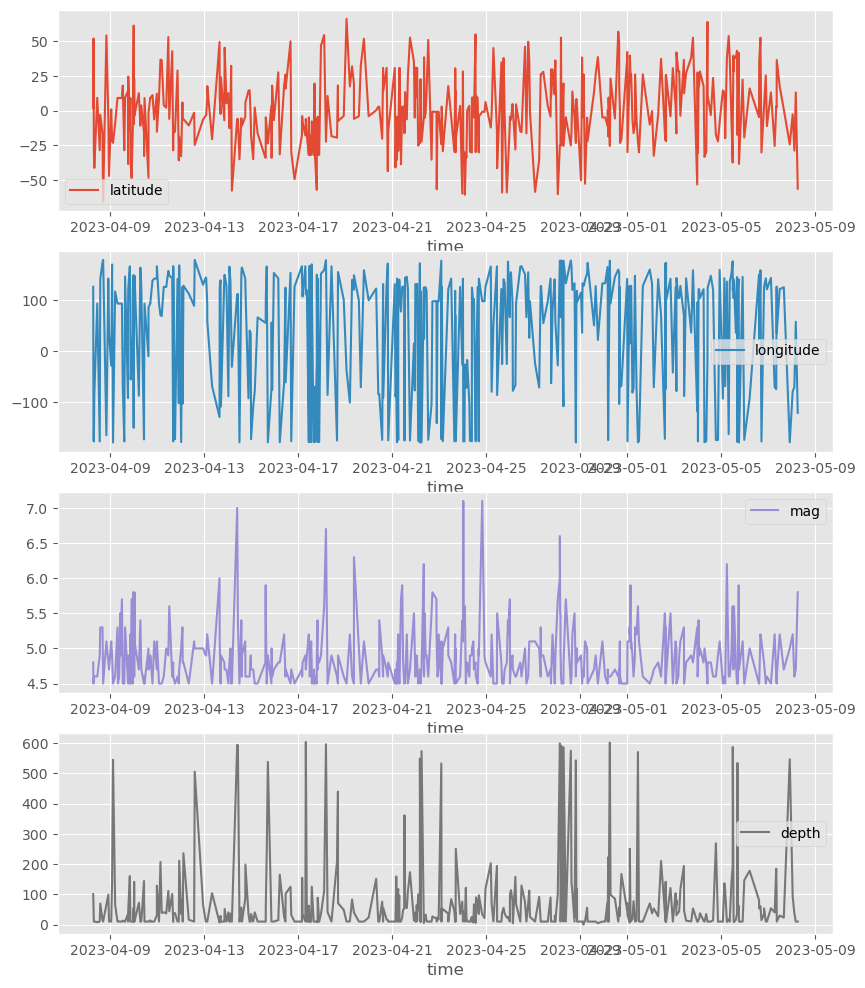

In [5]:
df.plot(subplots=True, figsize=(10, 12), sharex=False, sharey=False)

In [6]:
df.describe()

,latitude,longitude,mag,depth
count,452.000000,452.000000,452.000000,452.000000
mean,-0.751835,42.206556,4.878761,72.182954
std,26.291870,123.762853,0.418624,128.076583
min,-65.210500,-179.838700,4.500000,0.000000
25%,-20.314425,-73.033825,4.600000,10.000000
50%,-3.434700,99.814350,4.800000,22.827000
75%,17.514250,140.782950,5.100000,70.099000
max,65.818000,179.978900,7.100000,603.290000


Text(0.5, 1.0, 'depth')

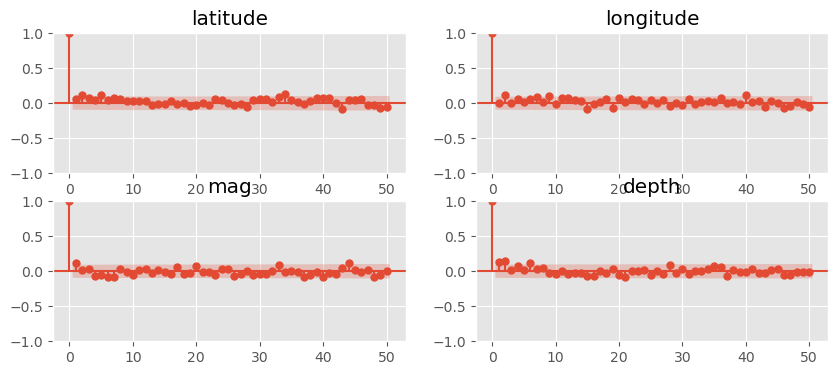

In [7]:
#plotear los acf de las variables que conforman df, cada grafico con titulo, de un tamaño no mayor a 10x4 y con 50 lags
fig, ax = plt.subplots(2, 2, figsize=(10, 4))
plot_acf(df['latitude'], ax=ax[0, 0], lags=50, title='latitude')
ax[0, 0].set_title('latitude')
plot_acf(df['longitude'], ax=ax[0, 1], lags=50, title='longitude')
ax[0, 1].set_title('longitude')
plot_acf(df['mag'], ax=ax[1, 0], lags=50, title='mag')
ax[1, 0].set_title('mag')
plot_acf(df['depth'], ax=ax[1, 1], lags=50, title='depth')
ax[1, 1].set_title('depth')



### Preparacion de los datos:

In [30]:
train = df.iloc[:442]
test = df.iloc[442 - 12:]
test_original = df.iloc[442:]

In [25]:
n_input = 12
n_features = 4
batch_size = 1

train_generator = TimeseriesGenerator(train.values, train.values,
                                        length=n_input, batch_size=batch_size)
test_generator = TimeseriesGenerator(test.values, test.values,
                                    length=n_input, batch_size=batch_size)

In [26]:
#cargar todos los datos del generador en x,y
train_x = np.array([])
train_y = np.array([])
test_x = np.array([])
test_y = np.array([])
for i in range(len(train_generator)):
    a, b = train_generator[i]
    train_x = np.append(train_x, a.flatten())
    train_y = np.append(train_y, b)
for i in range(len(test_generator)):
    a, b = test_generator[i]
    test_x = np.append(test_x, a.flatten())
    test_y = np.append(test_y, b)
    
train_x = train_x.reshape(-1, n_features, n_input)
train_y = train_y.reshape(-1, n_features)
test_x = test_x.reshape(-1, n_features, n_input)
test_y = test_y.reshape(-1, n_features)

print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

(430, 4, 12) (430, 4)
(10, 4, 12) (10, 4)


## Modelos:

### 1. Definicion del modelo LSTM:

In [15]:
model_lstm = Sequential()
model_lstm.add(LSTM(64, activation='tanh',input_shape=(n_features, n_input), return_sequences=True))
model_lstm.add(LSTM(32, activation='tanh',input_shape=(n_features, n_input), return_sequences=False))
model_lstm.add(Dense(32, activation='elu'))
model_lstm.add(Dense(16, activation='gelu'))
model_lstm.add(Dense(train_y.shape[1]))

model_lstm.compile(optimizer='adam', loss='mse', metrics=['mae'])

model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4, 64)             19712     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 4)                 68        
                                                                 
Total params: 33,780
Trainable params: 33,780
Non-trainable params: 0
_________________________________________________________________


In [16]:
#borrar todos los archivos del directorio D:\Universidad\MAESTRIAS\1_Maestría CIMAT\Aprendizaje de maquina I\Tarea 6\saved_models_lstm
import os, shutil
for i in os.listdir('./saved_models_lstm'):
    file_path = os.path.join('./saved_models_lstm', i)
    try:
        if os.path.isfile(file_path):
            os.unlink(file_path)
    except Exception as e:
        print(e)

In [17]:
model_dir = './saved_models_lstm/weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5'
checpoint = ModelCheckpoint(model_dir, 
                            monitor='val_loss', 
                            save_best_only=False,
                            verbose=1)

earlystop = EarlyStopping(monitor='val_loss', patience=7, verbose=1)

calbacks = [checpoint]#, earlystop]

In [18]:
history = model_lstm.fit(train_x, train_y,
                    epochs = 500,
                    batch_size = 16,
                    validation_split=0.1,
                    callbacks=calbacks,
                    verbose=1,
                    shuffle=False)


Epoch 1/500
22/25 [=========================>....] - ETA: 0s - loss: 10065.9072 - mae: 55.1218
Epoch 1: saving model to ./saved_models_lstm\weights-improvement-01-10040.32.hdf5
25/25 [==============================] - 5s 43ms/step - loss: 9848.4678 - mae: 54.8693 - val_loss: 10040.3223 - val_mae: 58.4957
Epoch 2/500
19/25 [=====================>........] - ETA: 0s - loss: 9622.0010 - mae: 54.0686
Epoch 2: saving model to ./saved_models_lstm\weights-improvement-02-9861.63.hdf5
25/25 [==============================] - 0s 8ms/step - loss: 9754.4668 - mae: 54.3020 - val_loss: 9861.6318 - val_mae: 57.1220
Epoch 3/500
19/25 [=====================>........] - ETA: 0s - loss: 9338.6182 - mae: 52.1284
Epoch 3: saving model to ./saved_models_lstm\weights-improvement-03-9394.85.hdf5
25/25 [==============================] - 0s 9ms/step - loss: 9417.6660 - mae: 52.0854 - val_loss: 9394.8535 - val_mae: 53.8140
Epoch 4/500
19/25 [=====================>........] - ETA: 0s - loss: 8883.7061 - mae: 49.9

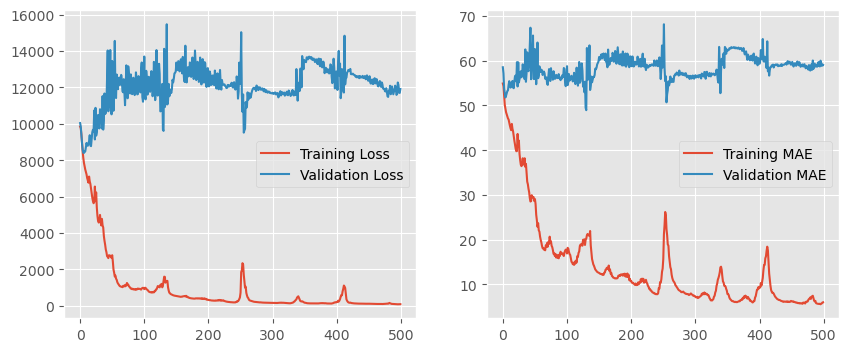

In [19]:
loss_per_epoch = history.history['loss']
val_loss_per_epoch = history.history['val_loss']
mae_per_epoch = history.history['mae']
val_mae_per_epoch = history.history['val_mae']

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(loss_per_epoch, label='Training Loss')
ax[0].plot(val_loss_per_epoch, label='Validation Loss')
ax[0].legend()
ax[1].plot(mae_per_epoch, label='Training MAE')
ax[1].plot(val_mae_per_epoch, label='Validation MAE')
ax[1].legend()  
plt.show()

In [53]:
model = keras.models.load_model('./saved_models_lstm/weights-improvement-485-11623.77.hdf5')

predictions = model.predict(test_x)
predictions_lstm = pd.DataFrame(predictions, columns=df.columns, index=test_original.index)
predictions_lstm

mse = mean_squared_error(test_y, predictions)
mae = mean_absolute_error(test_y, predictions)
rmse = np.sqrt(mse)
print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)


1/1 [==============================] - 1s 1s/step
MSE:  15208.634737536933
RMSE:  123.3232935723699
MAE:  66.38750294977964


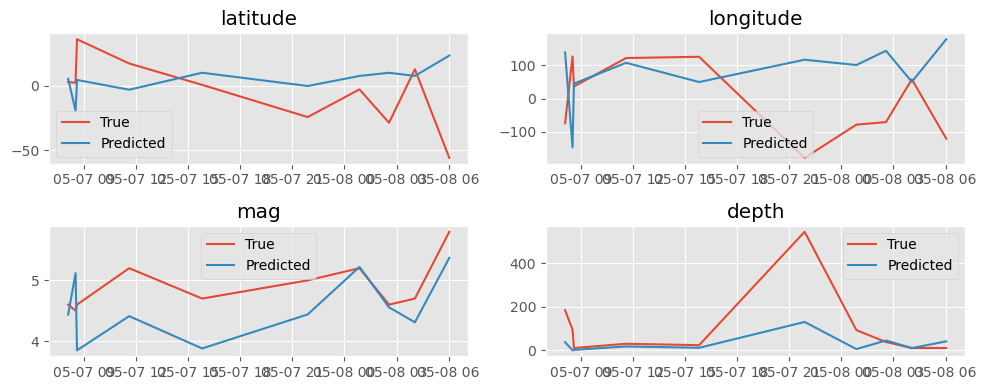

In [56]:
# Graficar las predicciones contra los datos reales
fig, ax = plt.subplots(2, 2, figsize=(10, 4))
for i, col in enumerate(predictions_lstm.columns):
    ax[i//2, i%2].plot(test_original[col], label='True')
    ax[i//2, i%2].plot(predictions_lstm[col], label='Predicted')
    ax[i//2, i%2].set_title(col)
    ax[i//2, i%2].legend()
plt.tight_layout()


### 2. Modelo RNN Vanilla:

In [64]:
#modelo RNN 

model_rnn = Sequential()
model_rnn.add(SimpleRNN(64, activation='tanh',input_shape=(n_features, n_input), return_sequences=True))
model_rnn.add(SimpleRNN(32, activation='tanh',input_shape=(n_features, n_input), return_sequences=False))
model_rnn.add(Dense(32, activation='elu'))
model_rnn.add(Dense(16, activation='gelu'))
model_rnn.add(Dense(train_y.shape[1]))

model_rnn.compile(optimizer='adam', loss='mse', metrics=['mae'])

model_rnn.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_6 (SimpleRNN)    (None, 4, 64)             4928      
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, 32)                3104      
                                                                 
 dense_12 (Dense)            (None, 32)                1056      
                                                                 
 dense_13 (Dense)            (None, 16)                528       
                                                                 
 dense_14 (Dense)            (None, 4)                 68        
                                                                 
Total params: 9,684
Trainable params: 9,684
Non-trainable params: 0
_________________________________________________________________


In [65]:
#borrar todos los archivos del directorio D:\Universidad\MAESTRIAS\1_Maestría CIMAT\Aprendizaje de maquina I\Tarea 6\saved_models_lstm
import os, shutil
for i in os.listdir('./saved_models_rnn'):
    file_path = os.path.join('./saved_models_rnn', i)
    try:
        if os.path.isfile(file_path):
            os.unlink(file_path)
    except Exception as e:
        print(e)

In [66]:
model_dir = './saved_models_rnn/weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5'
checpoint = ModelCheckpoint(model_dir, 
                            monitor='val_loss', 
                            save_best_only=False,
                            verbose=1)

calbacks = [checpoint]

In [67]:
history = model_rnn.fit(train_x, train_y,
                    epochs=500, 
                    batch_size=16,
                    validation_split=0.1,
                    callbacks=calbacks,
                    verbose=1,
                    shuffle=False)


Epoch 1/500
18/25 [====================>.........] - ETA: 0s - loss: 8455.6611 - mae: 52.3204 
Epoch 1: saving model to ./saved_models_rnn\weights-improvement-01-9997.22.hdf5
25/25 [==============================] - 3s 23ms/step - loss: 9824.3447 - mae: 54.5452 - val_loss: 9997.2168 - val_mae: 58.0196
Epoch 2/500
13/25 [==============>...............] - ETA: 0s - loss: 9208.6084 - mae: 52.6326
Epoch 2: saving model to ./saved_models_rnn\weights-improvement-02-9799.53.hdf5
25/25 [==============================] - 0s 7ms/step - loss: 9681.8838 - mae: 53.2588 - val_loss: 9799.5273 - val_mae: 56.1104
Epoch 3/500
14/25 [===============>..............] - ETA: 0s - loss: 8988.7324 - mae: 50.4980
Epoch 3: saving model to ./saved_models_rnn\weights-improvement-03-9473.23.hdf5
25/25 [==============================] - 0s 7ms/step - loss: 9421.8955 - mae: 51.6146 - val_loss: 9473.2266 - val_mae: 55.1463
Epoch 4/500
15/25 [=================>............] - ETA: 0s - loss: 8467.5605 - mae: 49.9058
E

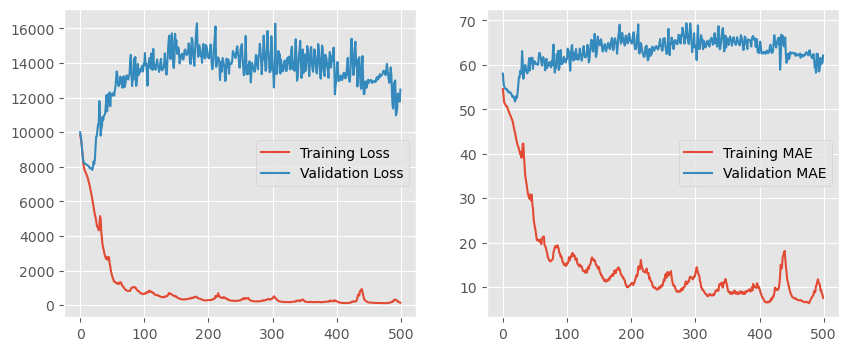

In [68]:
loss_per_epoch = history.history['loss']
val_loss_per_epoch = history.history['val_loss']
mae_per_epoch = history.history['mae']
val_mae_per_epoch = history.history['val_mae']

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(loss_per_epoch, label='Training Loss')
ax[0].plot(val_loss_per_epoch, label='Validation Loss')
ax[0].legend()
ax[1].plot(mae_per_epoch, label='Training MAE')
ax[1].plot(val_mae_per_epoch, label='Validation MAE')
ax[1].legend()  
plt.show()

In [78]:
model = keras.models.load_model('./saved_models_rnn/weights-improvement-495-11346.21.hdf5')

predictions = model.predict(test_x)
predictions_rnn = pd.DataFrame(predictions, columns=df.columns, index=test_original.index)
predictions_rnn

mse = mean_squared_error(test_y, predictions)
mae = mean_absolute_error(test_y, predictions)
rmse = np.sqrt(mse)
print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)

1/1 [==============================] - 0s 348ms/step
MSE:  14998.099837865902
RMSE:  122.46672951404354
MAE:  64.62138180004597


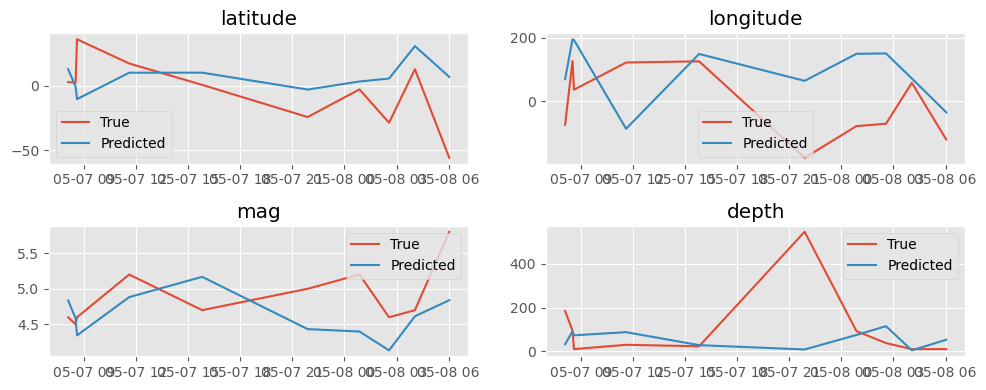

In [79]:
# Graficar las predicciones contra los datos reales
fig, ax = plt.subplots(2, 2, figsize=(10, 4))
for i, col in enumerate(predictions_rnn.columns):
    ax[i//2, i%2].plot(test_original[col], label='True')
    ax[i//2, i%2].plot(predictions_rnn[col], label='Predicted')
    ax[i//2, i%2].set_title(col)
    ax[i//2, i%2].legend()
plt.tight_layout()

### 3. Modelo GRU

In [83]:
#modelo GRU 
model_gru = Sequential()
model_gru.add(GRU(64, activation='tanh',input_shape=(n_features, n_input), return_sequences=True))
model_gru.add(GRU(32, activation='tanh',input_shape=(n_features, n_input), return_sequences=False))
model_gru.add(Dense(32, activation='elu'))
model_gru.add(Dense(16, activation='gelu'))
model_gru.add(Dense(train_y.shape[1]))

model_gru.compile(optimizer='adam', loss='mse', metrics = ['mae'])

model_gru.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 4, 64)             14976     
                                                                 
 gru_3 (GRU)                 (None, 32)                9408      
                                                                 
 dense_18 (Dense)            (None, 32)                1056      
                                                                 
 dense_19 (Dense)            (None, 16)                528       
                                                                 
 dense_20 (Dense)            (None, 4)                 68        
                                                                 
Total params: 26,036
Trainable params: 26,036
Non-trainable params: 0
_________________________________________________________________


In [82]:
#borrar todos los archivos del directorio D:\Universidad\MAESTRIAS\1_Maestría CIMAT\Aprendizaje de maquina I\Tarea 6\saved_models_lstm
import os, shutil
for i in os.listdir('./saved_models_gru'):
    file_path = os.path.join('./saved_models_gru', i)
    try:
        if os.path.isfile(file_path):
            os.unlink(file_path)
    except Exception as e:
        print(e)

In [84]:
model_dir = './saved_models_gru/weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5'
checpoint = ModelCheckpoint(model_dir, 
                            monitor='val_loss', 
                            save_best_only=False,
                            verbose=1)

calbacks = [checpoint]

In [85]:
history = model_gru.fit(train_x, train_y,
                    epochs=500, 
                    batch_size=16,
                    validation_split=0.1,
                    callbacks=calbacks,
                    shuffle=False)

Epoch 1/500
19/25 [=====================>........] - ETA: 0s - loss: 9665.1367 - mae: 54.4252 
Epoch 1: saving model to ./saved_models_gru\weights-improvement-01-9933.80.hdf5
25/25 [==============================] - 6s 43ms/step - loss: 9803.5234 - mae: 54.7465 - val_loss: 9933.7998 - val_mae: 58.0850
Epoch 2/500
25/25 [==============================] - ETA: 0s - loss: 9579.9561 - mae: 53.7566
Epoch 2: saving model to ./saved_models_gru\weights-improvement-02-9637.67.hdf5
25/25 [==============================] - 0s 9ms/step - loss: 9579.9561 - mae: 53.7566 - val_loss: 9637.6719 - val_mae: 56.3562
Epoch 3/500
18/25 [====================>.........] - ETA: 0s - loss: 8008.7759 - mae: 50.0547
Epoch 3: saving model to ./saved_models_gru\weights-improvement-03-9225.30.hdf5
25/25 [==============================] - 0s 9ms/step - loss: 9226.7158 - mae: 52.0223 - val_loss: 9225.2998 - val_mae: 54.5524
Epoch 4/500
17/25 [===================>..........] - ETA: 0s - loss: 7910.1406 - mae: 49.3423
E

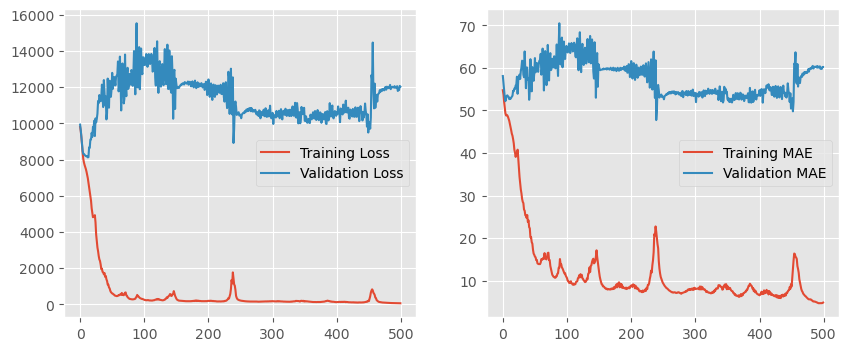

In [86]:
loss_per_epoch = history.history['loss']
val_loss_per_epoch = history.history['val_loss']
mae_per_epoch = history.history['mae']
val_mae_per_epoch = history.history['val_mae']

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(loss_per_epoch, label='Training Loss')
ax[0].plot(val_loss_per_epoch, label='Validation Loss')
ax[0].legend()
ax[1].plot(mae_per_epoch, label='Training MAE')
ax[1].plot(val_mae_per_epoch, label='Validation MAE')
ax[1].legend()  
plt.show()

In [87]:
#model = keras.models.load_model('./saved_models_gru/weights-improvement-495-11346.21.hdf5')

predictions = model_gru.predict(test_x)
predictions_gru = pd.DataFrame(predictions, columns=df.columns, index=test_original.index)
predictions_gru

mse = mean_squared_error(test_y, predictions)
mae = mean_absolute_error(test_y, predictions)
rmse = np.sqrt(mse)
print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)

1/1 [==============================] - 1s 722ms/step
MSE:  9481.315052136946
RMSE:  97.37204451040836
MAE:  55.96140435665131


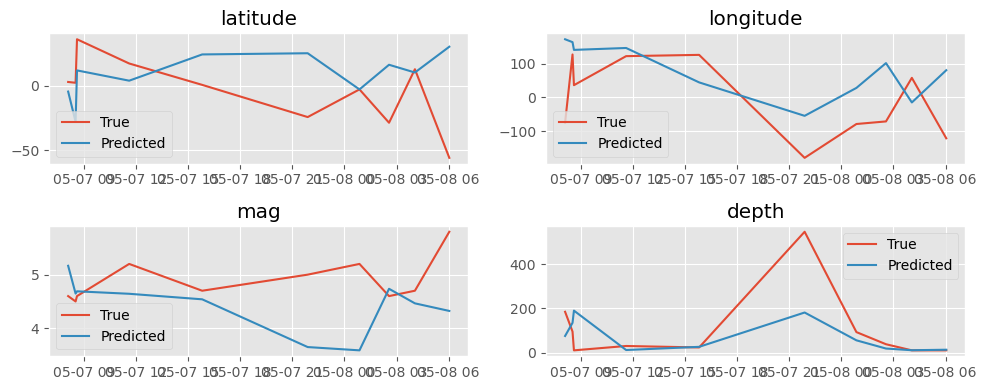

In [88]:
# Graficar las predicciones contra los datos reales
fig, ax = plt.subplots(2, 2, figsize=(10, 4))
for i, col in enumerate(predictions_gru.columns):
    ax[i//2, i%2].plot(test_original[col], label='True')
    ax[i//2, i%2].plot(predictions_gru[col], label='Predicted')
    ax[i//2, i%2].set_title(col)
    ax[i//2, i%2].legend()
plt.tight_layout()

### Grafica de los resultados:

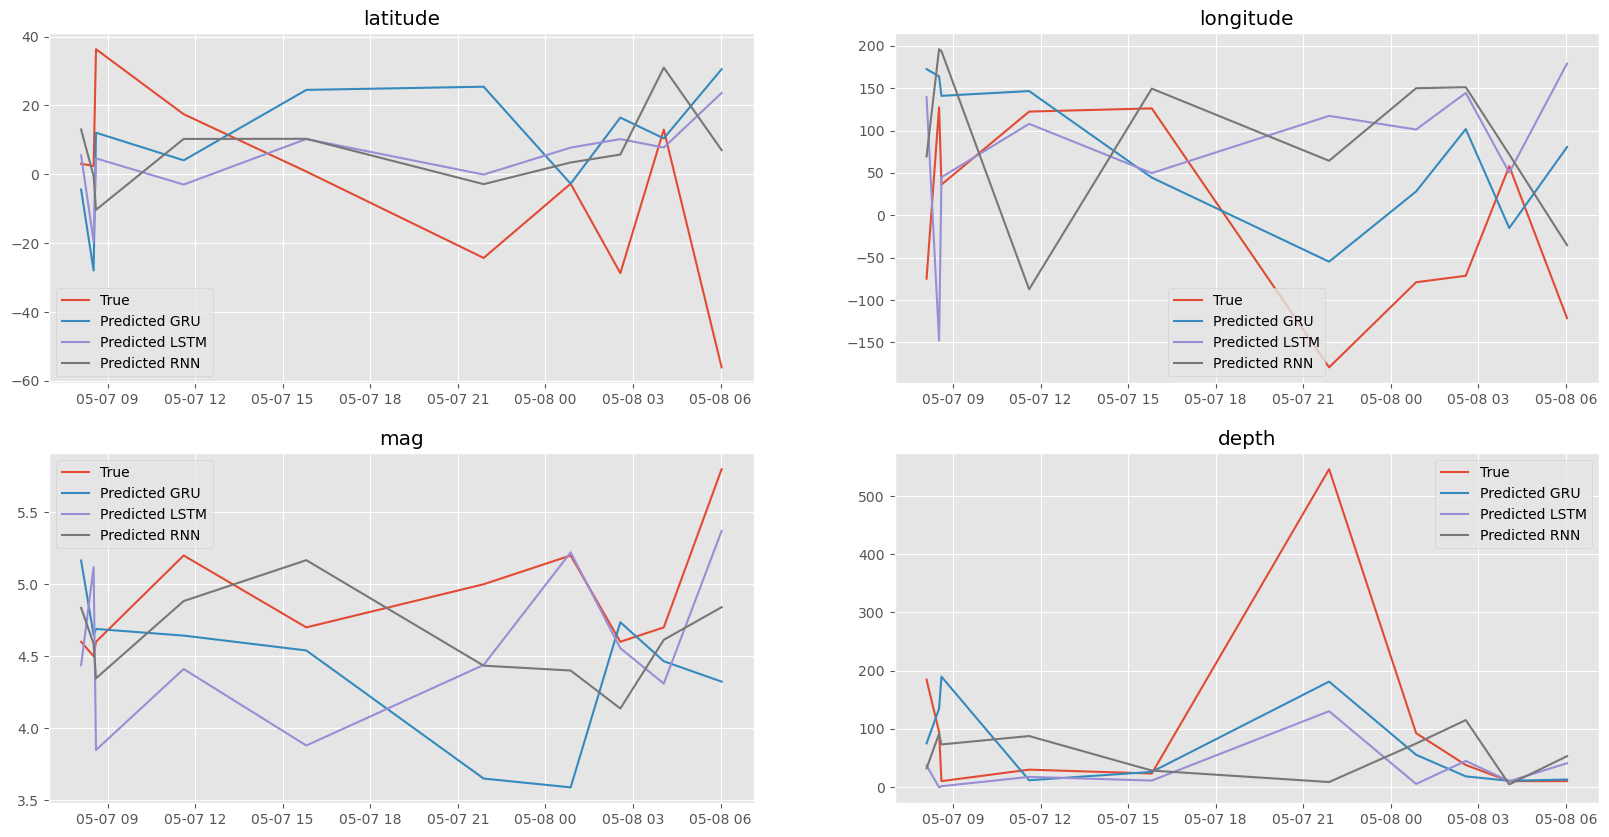

In [90]:
#Realizar una grafica que muestre las predicciones de los 3 modelos en una misma grafica

fig, ax = plt.subplots(2, 2, figsize=(20, 10))
for i, col in enumerate(predictions_gru.columns):
    ax[i//2, i%2].plot(test_original[col], label='True')
    ax[i//2, i%2].plot(predictions_gru[col], label='Predicted GRU')
    ax[i//2, i%2].plot(predictions_lstm[col], label='Predicted LSTM')
    ax[i//2, i%2].plot(predictions_rnn[col], label='Predicted RNN')
    ax[i//2, i%2].set_title(col)
    ax[i//2, i%2].legend()